In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## MNIST dataset

In [3]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [4]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [5]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [6]:
input_size = 784
output_size = 10

In [7]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
#         print(idx)
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [8]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [9]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=1, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [644]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        
#         self.centers = torch.randn(num_centers, input_dim)/3.
        self.centers = torch.rand(num_centers, input_dim)
        self.centers = nn.Parameter(self.centers)
        self.scaler = nn.Parameter(torch.Tensor([1.0]))
        
    def forward(self, x):
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        
        ### normalize similar to UMAP
        dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
        
        dists = dists/dists.std(dim=1, keepdim=True)
        dists = torch.exp(-dists*self.scaler)
        
        return dists
    
    def set_centroid_to_data_randomly(self, data_loader):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        self.centers.data = data_loader.dataset.data[indices].to(self.centers.device)
        pass
    
    def set_centroid_to_data_maxdist(self, data_loader):
        ## sample N points
        N = self.centers.shape[0]
        new_center = torch.empty_like(self.centers)
        min_dists = torch.empty(N)
        count = 0
        for i, (xx, _) in enumerate(tqdm(data_loader)):
            if count < N:
                if N-count < batch_size:
                    #### final fillup
                    new_center[count:count+N-count] = xx[:N-count]
                    xx = xx[N-count:]
                    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
                    min_dists = dists.min(dim=0)[0]
                    count = N

                else:#### fill the center
                    new_center[count:count+len(xx)] = xx
                    count += len(xx)
                    continue

            ammd = min_dists.argmin()
            for i, x in enumerate(xx):
                dists = torch.norm(new_center-x, dim=1)
                md = dists.min()
                if md > min_dists[ammd]:
                    min_dists[ammd] = md
                    new_center[ammd] = x
                    ammd = min_dists.argmin()
        self.centers.data = new_center.to(self.centers.device)
        pass
        
    
    def set_centroid_to_data(self, data_loader):
        new_center = self.centers.data.clone()
        min_dists = torch.ones(self.centers.shape[0])*1e9

        for xx, _ in data_loader:

            dists = torch.cdist(xx, self.centers.data)
            ### min dist of each center to the data points
            min_d, arg_md = dists.min(dim=0)

            ### dont allow same point to be assigned as closest to multiple centroid
            occupied = []
            for i in np.random.permutation(len(arg_md)):
        #     for i, ind in enumerate(arg_md):
                ind = arg_md[i]
                if ind in occupied:
                    min_d[i] = min_dists[i]
                    arg_md[i] = -1
                else:
                    occupied.append(ind)

            ### the index of centroids that have new min_dist
            idx = torch.nonzero(min_d<min_dists).reshape(-1)

            ### assign new_center to the nearest data point
            new_center[idx] = xx[arg_md[idx]]
            min_dists[idx] = min_d[idx]
            
        self.centers.data = new_center.to(self.centers.device)
        pass

In [637]:
dt = DistanceTransform(784, 20)

In [638]:
dists = dt(torch.randn(2, 784))

In [484]:
dists.shape

torch.Size([2, 20])

In [92]:
dt.set_centroid_to_data_randomly(train_loader)

In [93]:
dt.set_centroid_to_data(train_loader)

100%|██████████| 1200/1200 [00:04<00:00, 250.32it/s]


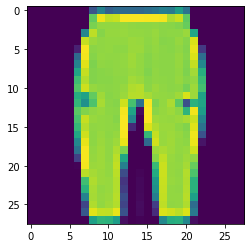

In [73]:
# plt.imshow(dt.centers.data[5].reshape(28,28))

In [26]:
new_center = dt.centers.data.clone()
min_dists = torch.ones(dt.centers.shape[0])*1e9

xd_idx = torch.ones(dt.centers.shape[0], dtype=torch.long)*-1

In [27]:
new_center.shape

torch.Size([20, 784])

In [28]:
########################
ii = -1
# for xx, _ in tqdm(test_loader):
for jj in tqdm(range(len(test_dataset)//batch_size)):
    xind = jj*batch_size+torch.arange(batch_size, dtype=torch.long)
#     print(xind)
    xx = test_dataset.data[xind]
    ii+=1
    dists = torch.cdist(xx, dt.centers.data)
    
    ### min dist of each center to the data points
    min_d, arg_md = dists.min(dim=0)
#     break
    
    ### dont allow same point to be assigned as closest to multiple centroid
    occupied = []
    for i in np.random.permutation(len(arg_md)):
#     for i, ind in enumerate(arg_md):
        ind = arg_md[i]
        if ind in occupied:
            min_d[i] = min_dists[i]
            arg_md[i] = -1
        else:
            occupied.append(ind)

    ### the index of centroids that have new min_dist
    idx = torch.nonzero(min_d<min_dists).reshape(-1)
    
    ### assign new_center to the nearest data point
    new_center[idx] = xx[arg_md[idx]]
    min_dists[idx] = min_d[idx]
    
#     indices = ii*batch_size + torch.arange(len(xx), dtype=torch.long)
    xd_idx[idx] = indices[idx]
    
#     print(indices[idx])
#     print(xind[idx])
#     print(idx)
    
#     for i in range(len(idx)):
#         i0 = idx[i]
#         i1 = xind[i]
#         plt.imshow(xx[i0].reshape(28,28), cmap='gray')
#         plt.show()
#         plt.imshow(test_dataset.data[i1].reshape(28,28), cmap='gray')
#         plt.show()
        
#     if ii == 5:
#         break
# #     break

100%|██████████| 200/200 [00:00<00:00, 850.80it/s]


In [419]:
### Initialize such that the input points are maximum distance with each other

In [485]:
dt.centers.shape

torch.Size([20, 784])

In [633]:
## sample N points
N = 220
new_center = torch.empty(N, 784)
min_dists = torch.empty(N)
count = 0
for i, (xx, _) in enumerate(tqdm(train_loader)):
    if count < N:
        if N-count < batch_size:
            #### final fillup
            new_center[count:count+N-count] = xx[:N-count]
            xx = xx[N-count:]
            dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
            min_dists = dists.min(dim=0)[0]
            count = N
            
            ## sort the centers according to min_dist
#             indx = min_dists.argsort()
#             min_dists = min_dists[indx]
#             new_center = new_center[indx]

        else:#### fill the center
            new_center[count:count+len(xx)] = xx
            count += len(xx)
            continue
            
#     print(min_dists)
    
    ammd = min_dists.argmin()
    for j, x in enumerate(xx):
        dists = torch.norm(new_center-x, dim=1)
        md = dists.min()
#         md = dists.mean()
#         md = dists.topk(N//4, largest=False)[0].mean()
        if md > min_dists[ammd]:
            min_dists[ammd] = md
            new_center[ammd] = x
            ammd = min_dists.argmin()
#             print(min_dists)
#         if dists.min() > min_dists.min():

#         break
            
#     dists = torch.cdist(xx, new_center)
#     mdist = dists.min(dim=1)[0]
#     for i, md in enumerate(mdist):
#         print(i, md)
#         if md > min_dists[0]:
            
#         break
#     print(i, min_dists.mean(), min_dists.min())
    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
    dists = dists.min(dim=0)[0]
    print(i, dists.mean(), dists.min())
    
#     break

  1%|          | 13/1200 [00:00<00:30, 39.48it/s]

4 tensor(5.5759) tensor(4.1559)
5 tensor(5.7867) tensor(4.5437)
6 tensor(5.9819) tensor(4.8363)
7 tensor(6.1298) tensor(5.0773)
8 tensor(6.3282) tensor(5.3152)
9 tensor(6.3695) tensor(5.4360)
10 tensor(6.4976) tensor(5.6185)
11 tensor(6.6505) tensor(5.7175)
12 tensor(6.7657) tensor(5.8093)


  1%|▏         | 17/1200 [00:00<00:32, 35.93it/s]

13 tensor(6.8048) tensor(5.8976)
14 tensor(6.8407) tensor(5.9626)
15 tensor(6.8966) tensor(6.0312)
16 tensor(6.9889) tensor(6.1033)
17 tensor(7.0340) tensor(6.1665)
18 tensor(7.0742) tensor(6.1999)
19 tensor(7.1078) tensor(6.2545)


  2%|▏         | 24/1200 [00:00<00:42, 27.56it/s]

20 tensor(7.1301) tensor(6.3041)
21 tensor(7.1476) tensor(6.4322)
22 tensor(7.2042) tensor(6.4700)
23 tensor(7.2258) tensor(6.4974)
24 tensor(7.2493) tensor(6.5300)
25 tensor(7.2733) tensor(6.5710)
26 tensor(7.3359) tensor(6.6363)


  3%|▎         | 31/1200 [00:01<00:42, 27.74it/s]

27 tensor(7.4292) tensor(6.6755)
28 tensor(7.4396) tensor(6.7121)
29 tensor(7.4642) tensor(6.7667)
30 tensor(7.4999) tensor(6.7949)
31 tensor(7.5509) tensor(6.8159)


  3%|▎         | 38/1200 [00:01<01:02, 18.69it/s]

32 tensor(7.5654) tensor(6.8375)
33 tensor(7.5802) tensor(6.8518)
34 tensor(7.6339) tensor(6.9067)
35 tensor(7.6382) tensor(6.9309)
36 tensor(7.6357) tensor(6.9710)
37 tensor(7.6743) tensor(7.0155)


  4%|▍         | 45/1200 [00:01<00:58, 19.87it/s]

38 tensor(7.6798) tensor(7.0282)
39 tensor(7.6938) tensor(7.0688)
40 tensor(7.6950) tensor(7.0843)
41 tensor(7.7138) tensor(7.1024)
42 tensor(7.7577) tensor(7.1260)
43 tensor(7.7751) tensor(7.1617)
44 tensor(7.8233) tensor(7.1745)
45 tensor(7.8261) tensor(7.1958)


  4%|▍         | 52/1200 [00:02<00:47, 24.26it/s]

46 tensor(7.8609) tensor(7.2314)
47 tensor(7.8568) tensor(7.2464)
48 tensor(7.8627) tensor(7.2471)
49 tensor(7.8750) tensor(7.2949)
50 tensor(7.8965) tensor(7.2949)
51 tensor(7.9499) tensor(7.3151)
52 tensor(7.9508) tensor(7.3463)
53 tensor(7.9978) tensor(7.3662)


  5%|▍         | 59/1200 [00:02<00:41, 27.53it/s]

54 tensor(8.0256) tensor(7.4089)
55 tensor(8.0533) tensor(7.4207)
56 tensor(8.0680) tensor(7.4290)
57 tensor(8.0917) tensor(7.4487)
58 tensor(8.0843) tensor(7.4587)
59 tensor(8.1331) tensor(7.4789)
60 tensor(8.1423) tensor(7.4789)
61 tensor(8.1579) tensor(7.4941)


  6%|▌         | 66/1200 [00:02<00:46, 24.15it/s]

62 tensor(8.1732) tensor(7.5055)
63 tensor(8.1905) tensor(7.5130)
64 tensor(8.1905) tensor(7.5130)
65 tensor(8.2073) tensor(7.5277)
66 tensor(8.2373) tensor(7.5506)
67 tensor(8.2449) tensor(7.5650)
68 tensor(8.2719) tensor(7.5991)


  6%|▌         | 74/1200 [00:03<00:40, 27.87it/s]

69 tensor(8.2984) tensor(7.6149)
70 tensor(8.2860) tensor(7.6295)
71 tensor(8.2864) tensor(7.6386)
72 tensor(8.2905) tensor(7.6591)
73 tensor(8.3090) tensor(7.6948)
74 tensor(8.3078) tensor(7.6901)
75 tensor(8.3155) tensor(7.6901)


  7%|▋         | 81/1200 [00:03<00:37, 29.86it/s]

76 tensor(8.3349) tensor(7.7129)
77 tensor(8.3557) tensor(7.7265)
78 tensor(8.3551) tensor(7.7402)
79 tensor(8.3544) tensor(7.7402)
80 tensor(8.3768) tensor(7.7438)
81 tensor(8.3667) tensor(7.7438)
82 tensor(8.3810) tensor(7.7755)


  8%|▊         | 90/1200 [00:03<00:38, 29.20it/s]

83 tensor(8.3927) tensor(7.8054)
84 tensor(8.3936) tensor(7.8150)
85 tensor(8.3882) tensor(7.8190)
86 tensor(8.4206) tensor(7.8405)
87 tensor(8.4479) tensor(7.8564)
88 tensor(8.4490) tensor(7.8575)
89 tensor(8.4723) tensor(7.8660)
90 tensor(8.4929) tensor(7.8847)
91 tensor(8.5099) tensor(7.8939)


  8%|▊         | 99/1200 [00:03<00:32, 33.44it/s]

92 tensor(8.5203) tensor(7.9206)
93 tensor(8.5209) tensor(7.9206)
94 tensor(8.5264) tensor(7.9206)
95 tensor(8.5264) tensor(7.9206)
96 tensor(8.5389) tensor(7.9323)
97 tensor(8.5405) tensor(7.9340)
98 tensor(8.5596) tensor(7.9438)
99 tensor(8.5568) tensor(7.9566)


  9%|▊         | 103/1200 [00:03<00:33, 32.89it/s]

100 tensor(8.5628) tensor(7.9566)
101 tensor(8.5726) tensor(7.9569)
102 tensor(8.5941) tensor(7.9833)
103 tensor(8.5961) tensor(7.9871)
104 tensor(8.6012) tensor(8.0061)


  9%|▉         | 107/1200 [00:04<01:06, 16.40it/s]

105 tensor(8.6026) tensor(8.0071)
106 tensor(8.6003) tensor(8.0297)
107 tensor(8.6158) tensor(8.0317)
108 tensor(8.6226) tensor(8.0353)


  9%|▉         | 113/1200 [00:04<01:02, 17.52it/s]

109 tensor(8.6241) tensor(8.0472)
110 tensor(8.6340) tensor(8.0555)
111 tensor(8.6312) tensor(8.0573)
112 tensor(8.6432) tensor(8.0666)
113 tensor(8.6424) tensor(8.0824)
114 tensor(8.6359) tensor(8.0943)
115 tensor(8.6306) tensor(8.0943)


 10%|█         | 122/1200 [00:05<00:45, 23.63it/s]

116 tensor(8.6274) tensor(8.0943)
117 tensor(8.6334) tensor(8.1065)
118 tensor(8.6471) tensor(8.1112)
119 tensor(8.6510) tensor(8.1112)
120 tensor(8.6706) tensor(8.1195)
121 tensor(8.6829) tensor(8.1268)
122 tensor(8.6967) tensor(8.1400)
123 tensor(8.7215) tensor(8.1459)


 10%|█         | 125/1200 [00:05<00:55, 19.41it/s]

124 tensor(8.7248) tensor(8.1521)
125 tensor(8.7378) tensor(8.1552)
126 tensor(8.7563) tensor(8.1742)


 11%|█         | 131/1200 [00:05<01:03, 16.95it/s]

127 tensor(8.7541) tensor(8.1756)
128 tensor(8.7513) tensor(8.1958)
129 tensor(8.7608) tensor(8.1958)
130 tensor(8.7608) tensor(8.1958)


 12%|█▏        | 140/1200 [00:06<00:41, 25.33it/s]

131 tensor(8.7670) tensor(8.1995)
132 tensor(8.7629) tensor(8.2012)
133 tensor(8.7992) tensor(8.2154)
134 tensor(8.8140) tensor(8.2267)
135 tensor(8.8131) tensor(8.2267)
136 tensor(8.8205) tensor(8.2373)
137 tensor(8.8180) tensor(8.2403)
138 tensor(8.8286) tensor(8.2515)
139 tensor(8.8181) tensor(8.2583)


 12%|█▏        | 146/1200 [00:06<00:41, 25.66it/s]

140 tensor(8.8297) tensor(8.2637)
141 tensor(8.8525) tensor(8.2696)
142 tensor(8.8796) tensor(8.2883)
143 tensor(8.8752) tensor(8.2883)
144 tensor(8.8686) tensor(8.2883)
145 tensor(8.8772) tensor(8.2976)


 12%|█▏        | 149/1200 [00:06<00:39, 26.60it/s]

146 tensor(8.8616) tensor(8.2994)
147 tensor(8.8639) tensor(8.3006)
148 tensor(8.8722) tensor(8.3120)
149 tensor(8.8700) tensor(8.3120)


 13%|█▎        | 157/1200 [00:06<00:40, 25.63it/s]

150 tensor(8.8700) tensor(8.3120)
151 tensor(8.8874) tensor(8.3250)
152 tensor(8.8858) tensor(8.3458)
153 tensor(8.8887) tensor(8.3602)
154 tensor(8.8942) tensor(8.3602)
155 tensor(8.9006) tensor(8.3624)
156 tensor(8.9006) tensor(8.3624)
157 tensor(8.9016) tensor(8.3624)


 13%|█▎        | 160/1200 [00:06<00:39, 26.34it/s]

158 tensor(8.9098) tensor(8.3631)
159 tensor(8.9262) tensor(8.3673)


 14%|█▎        | 163/1200 [00:07<00:51, 20.32it/s]

160 tensor(8.9418) tensor(8.3754)
161 tensor(8.9449) tensor(8.3754)
162 tensor(8.9448) tensor(8.4003)


 14%|█▍        | 170/1200 [00:07<01:01, 16.68it/s]

163 tensor(8.9598) tensor(8.4053)
164 tensor(8.9535) tensor(8.4053)
165 tensor(8.9511) tensor(8.4053)
166 tensor(8.9568) tensor(8.4186)
167 tensor(8.9451) tensor(8.4186)
168 tensor(8.9530) tensor(8.4286)
169 tensor(8.9523) tensor(8.4333)


 15%|█▍        | 177/1200 [00:07<00:49, 20.49it/s]

170 tensor(8.9599) tensor(8.4333)
171 tensor(8.9639) tensor(8.4454)
172 tensor(8.9648) tensor(8.4526)
173 tensor(8.9615) tensor(8.4526)
174 tensor(8.9857) tensor(8.4576)
175 tensor(9.0097) tensor(8.4755)
176 tensor(9.0100) tensor(8.4873)
177 tensor(9.0143) tensor(8.4923)


 15%|█▌        | 180/1200 [00:08<00:53, 19.17it/s]

178 tensor(9.0198) tensor(8.4923)
179 tensor(9.0361) tensor(8.5030)
180 tensor(9.0393) tensor(8.5030)


 16%|█▌        | 187/1200 [00:08<00:43, 23.45it/s]

181 tensor(9.0401) tensor(8.5059)
182 tensor(9.0401) tensor(8.5059)
183 tensor(9.0401) tensor(8.5130)
184 tensor(9.0318) tensor(8.5130)
185 tensor(9.0255) tensor(8.5268)
186 tensor(9.0198) tensor(8.5268)


 16%|█▌        | 194/1200 [00:08<00:41, 24.16it/s]

187 tensor(9.0165) tensor(8.5268)
188 tensor(9.0165) tensor(8.5268)
189 tensor(9.0224) tensor(8.5268)
190 tensor(9.0272) tensor(8.5331)
191 tensor(9.0340) tensor(8.5367)
192 tensor(9.0480) tensor(8.5400)
193 tensor(9.0577) tensor(8.5584)
194 tensor(9.0675) tensor(8.5584)


 16%|█▋        | 197/1200 [00:08<00:47, 21.17it/s]

195 tensor(9.0675) tensor(8.5584)
196 tensor(9.0700) tensor(8.5584)
197 tensor(9.0700) tensor(8.5584)
198 tensor(9.0767) tensor(8.5627)
199 tensor(9.0873) tensor(8.5740)


 17%|█▋        | 205/1200 [00:09<00:36, 27.50it/s]

200 tensor(9.0880) tensor(8.5740)
201 tensor(9.0912) tensor(8.5740)
202 tensor(9.0912) tensor(8.5740)
203 tensor(9.0966) tensor(8.5763)
204 tensor(9.0966) tensor(8.5763)


 18%|█▊        | 213/1200 [00:09<00:38, 25.57it/s]

205 tensor(9.1093) tensor(8.5955)
206 tensor(9.1130) tensor(8.5955)
207 tensor(9.1197) tensor(8.5958)
208 tensor(9.1245) tensor(8.5958)
209 tensor(9.1300) tensor(8.5959)
210 tensor(9.1113) tensor(8.6082)
211 tensor(9.1130) tensor(8.6163)
212 tensor(9.1130) tensor(8.6163)


 18%|█▊        | 220/1200 [00:09<00:39, 25.00it/s]

213 tensor(9.1130) tensor(8.6163)
214 tensor(9.1156) tensor(8.6163)
215 tensor(9.1301) tensor(8.6231)
216 tensor(9.1280) tensor(8.6231)
217 tensor(9.1436) tensor(8.6348)
218 tensor(9.1332) tensor(8.6348)
219 tensor(9.1332) tensor(8.6348)


 19%|█▊        | 223/1200 [00:09<00:45, 21.44it/s]

220 tensor(9.1307) tensor(8.6348)
221 tensor(9.1382) tensor(8.6348)
222 tensor(9.1549) tensor(8.6434)
223 tensor(9.1534) tensor(8.6434)


 19%|█▉        | 226/1200 [00:10<00:42, 23.18it/s]

224 tensor(9.1610) tensor(8.6555)
225 tensor(9.1610) tensor(8.6555)
226 tensor(9.1675) tensor(8.6555)
227 tensor(9.1615) tensor(8.6632)
228 tensor(9.1628) tensor(8.6632)
229 tensor(9.1711) tensor(8.6823)


 20%|█▉        | 234/1200 [00:10<00:55, 17.26it/s]

230 tensor(9.1711) tensor(8.6823)
231 tensor(9.1655) tensor(8.6823)
232 tensor(9.1654) tensor(8.6823)
233 tensor(9.1654) tensor(8.6823)
234 tensor(9.1601) tensor(8.6823)
235 

 20%|█▉        | 238/1200 [00:10<00:47, 20.44it/s]

tensor(9.1601) tensor(8.6823)
236 tensor(9.1619) tensor(8.6823)
237 tensor(9.1652) tensor(8.6823)
238 tensor(9.1823) tensor(8.7001)
239 tensor(9.1823) tensor(8.7001)
240 tensor(9.1786) tensor(8.7001)


 20%|██        | 245/1200 [00:11<00:43, 22.12it/s]

241 tensor(9.1822) tensor(8.7001)
242 tensor(9.1836) tensor(8.7001)
243 tensor(9.1842) tensor(8.7009)
244 tensor(9.1938) tensor(8.7037)
245 tensor(9.1907) tensor(8.7037)
246 tensor(9.2124) tensor(8.7124)
247 tensor(9.2230) tensor(8.7124)


 21%|██        | 252/1200 [00:11<00:36, 25.68it/s]

248 tensor(9.2202) tensor(8.7188)
249 tensor(9.2340) tensor(8.7194)
250 tensor(9.2325) tensor(8.7282)
251 tensor(9.2325) tensor(8.7282)
252 tensor(9.2414) tensor(8.7407)
253 tensor(9.2414) tensor(8.7407)


 22%|██▏       | 259/1200 [00:11<00:34, 27.21it/s]

254 tensor(9.2481) tensor(8.7407)
255 tensor(9.2655) tensor(8.7407)
256 tensor(9.2655) tensor(8.7407)
257 tensor(9.2655) tensor(8.7407)
258 tensor(9.2727) tensor(8.7407)
259 tensor(9.2770) tensor(8.7504)
260 tensor(9.2878) tensor(8.7533)
261 tensor(9.2852) tensor(8.7533)


 22%|██▏       | 267/1200 [00:11<00:33, 27.58it/s]

262 tensor(9.2852) tensor(8.7533)
263 tensor(9.2900) tensor(8.7533)
264 tensor(9.3001) tensor(8.7636)
265 tensor(9.3001) tensor(8.7636)
266 tensor(9.2985) tensor(8.7636)
267 tensor(9.2985) tensor(8.7655)


 22%|██▎       | 270/1200 [00:11<00:33, 27.77it/s]

268 tensor(9.3060) tensor(8.7655)
269 tensor(9.3077) tensor(8.7655)
270 tensor(9.3077) tensor(8.7655)


 23%|██▎       | 277/1200 [00:12<00:40, 22.80it/s]

271 tensor(9.3078) tensor(8.7673)
272 tensor(9.3078) tensor(8.7673)
273 tensor(9.3078) tensor(8.7673)
274 tensor(9.3117) tensor(8.7673)
275 tensor(9.3245) tensor(8.7719)
276 tensor(9.3395) tensor(8.7748)
277 tensor(9.3371) tensor(8.7748)


 23%|██▎       | 280/1200 [00:12<00:39, 23.11it/s]

278 tensor(9.3424) tensor(8.7799)
279 tensor(9.3393) tensor(8.7904)
280 tensor(9.3390) tensor(8.7904)


 24%|██▍       | 287/1200 [00:12<00:40, 22.71it/s]

281 tensor(9.3376) tensor(8.7904)
282 tensor(9.3421) tensor(8.7951)
283 tensor(9.3421) tensor(8.7951)
284 tensor(9.3421) tensor(8.7951)
285 tensor(9.3427) tensor(8.7989)
286 tensor(9.3499) tensor(8.7989)
287 tensor(9.3499) tensor(8.7989)
288 tensor(9.3510) tensor(8.8095)


 24%|██▍       | 293/1200 [00:13<00:39, 22.95it/s]

289 tensor(9.3618) tensor(8.8126)
290 tensor(9.3640) tensor(8.8194)
291 tensor(9.3590) tensor(8.8258)
292 tensor(9.3590) tensor(8.8258)
293 tensor(9.3590) tensor(8.8258)


 25%|██▍       | 296/1200 [00:13<00:37, 23.96it/s]

294 tensor(9.3616) tensor(8.8258)
295 tensor(9.3616) tensor(8.8258)


 25%|██▌       | 303/1200 [00:13<00:44, 20.21it/s]

296 tensor(9.3616) tensor(8.8258)
297 tensor(9.3616) tensor(8.8258)
298 tensor(9.3592) tensor(8.8439)
299 tensor(9.3691) tensor(8.8451)
300 tensor(9.3691) tensor(8.8451)
301 tensor(9.3665) tensor(8.8451)
302 tensor(9.3624) tensor(8.8451)


 26%|██▌       | 310/1200 [00:13<00:43, 20.54it/s]

303 tensor(9.3596) tensor(8.8451)
304 tensor(9.3596) tensor(8.8451)
305 tensor(9.3471) tensor(8.8467)
306 tensor(9.3538) tensor(8.8471)
307 tensor(9.3618) tensor(8.8615)
308 tensor(9.3621) tensor(8.8615)
309 tensor(9.3621) tensor(8.8615)
310 tensor(9.3478) tensor(8.8615)


 26%|██▋       | 318/1200 [00:14<00:32, 27.27it/s]

311 tensor(9.3491) tensor(8.8615)
312 tensor(9.3559) tensor(8.8704)
313 tensor(9.3559) tensor(8.8704)
314 tensor(9.3559) tensor(8.8704)
315 tensor(9.3559) tensor(8.8704)
316 tensor(9.3622) tensor(8.8789)
317 tensor(9.3625) tensor(8.8789)
318 tensor(9.3567) tensor(8.8789)


 27%|██▋       | 325/1200 [00:14<00:33, 26.06it/s]

319 tensor(9.3691) tensor(8.8832)
320 tensor(9.3764) tensor(8.8871)
321 tensor(9.3764) tensor(8.8871)
322 tensor(9.3764) tensor(8.8871)
323 tensor(9.3764) tensor(8.8871)
324 tensor(9.3764) tensor(8.8871)


 27%|██▋       | 329/1200 [00:14<00:30, 28.14it/s]

325 tensor(9.3775) tensor(8.8911)
326 tensor(9.3771) tensor(8.8911)
327 tensor(9.3711) tensor(8.8911)
328 tensor(9.3688) tensor(8.8911)
329 tensor(9.3664) tensor(8.8963)
330 tensor(9.3702) tensor(8.8963)
331 tensor(9.3674) tensor(8.8963)


 28%|██▊       | 336/1200 [00:14<00:36, 23.85it/s]

332 tensor(9.3750) tensor(8.8994)
333 tensor(9.3750) tensor(8.8994)
334 tensor(9.3750) tensor(8.8994)
335 tensor(9.3750) tensor(8.8994)
336 tensor(9.3804) tensor(8.8994)
337 tensor(9.3804) tensor(8.8994)
338 tensor(9.3805) tensor(8.9008)


 29%|██▊       | 343/1200 [00:15<00:38, 22.08it/s]

339 tensor(9.3805) tensor(8.9008)
340 tensor(9.3863) tensor(8.9011)
341 tensor(9.3945) tensor(8.9156)
342 tensor(9.3952) tensor(8.9197)
343 tensor(9.3995) tensor(8.9222)


 29%|██▉       | 347/1200 [00:15<00:33, 25.22it/s]

344 tensor(9.3995) tensor(8.9222)
345 tensor(9.3972) tensor(8.9222)
346 tensor(9.3972) tensor(8.9222)


 30%|██▉       | 354/1200 [00:15<00:35, 23.87it/s]

347 tensor(9.3972) tensor(8.9222)
348 tensor(9.3972) tensor(8.9222)
349 tensor(9.3995) tensor(8.9222)
350 tensor(9.3995) tensor(8.9222)
351 tensor(9.4058) tensor(8.9222)
352 tensor(9.4058) tensor(8.9222)
353 tensor(9.4090) tensor(8.9222)
354 tensor(9.4090) tensor(8.9222)


 30%|██▉       | 357/1200 [00:15<00:39, 21.11it/s]

355 tensor(9.4110) tensor(8.9227)
356 tensor(9.4224) tensor(8.9255)
357 tensor(9.4243) tensor(8.9269)


 30%|███       | 360/1200 [00:16<00:39, 21.46it/s]

358 tensor(9.4243) tensor(8.9269)
359 tensor(9.4307) tensor(8.9340)
360 tensor(9.4307) tensor(8.9340)


 31%|███       | 367/1200 [00:16<00:47, 17.62it/s]

361 tensor(9.4307) tensor(8.9340)
362 tensor(9.4307) tensor(8.9340)
363 tensor(9.4307) tensor(8.9340)
364 tensor(9.4377) tensor(8.9340)
365 tensor(9.4374) tensor(8.9340)
366 tensor(9.4411) tensor(8.9427)
367 tensor(9.4411) tensor(8.9427)
368 tensor(9.4489) tensor(8.9427)


 31%|███       | 371/1200 [00:16<00:43, 19.01it/s]

369 tensor(9.4559) tensor(8.9459)
370 tensor(9.4496) tensor(8.9459)
371 tensor(9.4474) tensor(8.9471)
372 tensor(9.4474) tensor(8.9471)


 32%|███▏      | 379/1200 [00:17<00:33, 24.23it/s]

373 tensor(9.4459) tensor(8.9471)
374 tensor(9.4475) tensor(8.9587)
375 tensor(9.4407) tensor(8.9587)
376 tensor(9.4417) tensor(8.9587)
377 tensor(9.4417) tensor(8.9587)
378 tensor(9.4417) tensor(8.9587)
379 tensor(9.4430) tensor(8.9587)


 32%|███▏      | 386/1200 [00:17<00:32, 25.09it/s]

380 tensor(9.4595) tensor(8.9653)
381 tensor(9.4606) tensor(8.9656)
382 tensor(9.4646) tensor(8.9752)
383 tensor(9.4690) tensor(8.9752)
384 tensor(9.4656) tensor(8.9943)
385 tensor(9.4765) tensor(8.9943)
386 tensor(9.4765) tensor(8.9943)
387 tensor(9.4765) tensor(8.9943)


 32%|███▎      | 390/1200 [00:17<00:36, 22.35it/s]

388 tensor(9.4804) tensor(8.9943)
389 tensor(9.4786) tensor(8.9943)
390 tensor(9.4786) tensor(8.9943)
391 tensor(9.4786) tensor(8.9943)


 33%|███▎      | 394/1200 [00:17<00:32, 24.83it/s]

392 tensor(9.4800) tensor(8.9975)
393 tensor(9.4828) tensor(9.0044)
394 tensor(9.4828) tensor(9.0044)
395 tensor(9.4885) tensor(9.0069)
396 tensor(9.4967) tensor(9.0165)
397 tensor(9.4967) tensor(9.0165)


 34%|███▎      | 402/1200 [00:17<00:31, 25.10it/s]

398 tensor(9.5004) tensor(9.0165)
399 tensor(9.5004) tensor(9.0165)
400 tensor(9.5057) tensor(9.0199)
401 tensor(9.5080) tensor(9.0199)
402 tensor(9.5074) tensor(9.0223)
403 tensor(9.5159) tensor(9.0266)


 34%|███▍      | 406/1200 [00:18<00:29, 27.02it/s]

404 tensor(9.5243) tensor(9.0266)
405 tensor(9.5243) tensor(9.0266)
406 tensor(9.5314) tensor(9.0642)
407 tensor(9.5268) tensor(9.0642)
408 tensor(9.5268) tensor(9.0642)


 34%|███▍      | 414/1200 [00:18<00:30, 25.65it/s]

409 tensor(9.5177) tensor(9.0501)
410 tensor(9.5177) tensor(9.0501)
411 tensor(9.5185) tensor(9.0642)
412 tensor(9.5185) tensor(9.0642)
413 tensor(9.5240) tensor(9.0642)
414 tensor(9.5240) tensor(9.0642)
415 tensor(9.5370) tensor(9.0697)
416 tensor(9.5313) tensor(9.0697)


 35%|███▌      | 421/1200 [00:18<00:34, 22.86it/s]

417 tensor(9.5281) tensor(9.0753)
418 tensor(9.5281) tensor(9.0753)
419 tensor(9.5281) tensor(9.0753)
420 tensor(9.5320) tensor(9.0753)


 36%|███▌      | 429/1200 [00:18<00:27, 28.06it/s]

421 tensor(9.5316) tensor(9.0761)
422 tensor(9.5326) tensor(9.0771)
423 tensor(9.5326) tensor(9.0771)
424 tensor(9.5435) tensor(9.0838)
425 tensor(9.5435) tensor(9.0838)
426 tensor(9.5401) tensor(9.0838)
427 tensor(9.5401) tensor(9.0838)
428 tensor(9.5478) tensor(9.0882)
429 tensor(9.5507) tensor(9.0882)
430 tensor(9.5507) tensor(9.0882)
431 tensor(9.5517) tensor(9.0897)


 36%|███▋      | 436/1200 [00:19<00:41, 18.50it/s]

432 tensor(9.5517) tensor(9.0897)
433 tensor(9.5586) tensor(9.0910)
434 tensor(9.5680) tensor(9.1036)
435 tensor(9.5818) tensor(9.1036)


 37%|███▋      | 443/1200 [00:19<00:31, 23.85it/s]

436 tensor(9.5818) tensor(9.1036)
437 tensor(9.5818) tensor(9.1036)
438 tensor(9.5830) tensor(9.1114)
439 tensor(9.5830) tensor(9.1114)
440 tensor(9.5801) tensor(9.1239)
441 tensor(9.5740) tensor(9.1239)
442 tensor(9.5740) tensor(9.1239)
443 tensor(9.5766) tensor(9.1239)


 37%|███▋      | 446/1200 [00:19<00:35, 21.22it/s]

444 tensor(9.5726) tensor(9.1239)
445 tensor(9.5753) tensor(9.1244)
446 tensor(9.5682) tensor(9.1338)
447 tensor(9.5651) tensor(9.1338)
448 tensor(9.5638) tensor(9.1338)


 38%|███▊      | 453/1200 [00:20<00:33, 22.60it/s]

449 tensor(9.5638) tensor(9.1338)
450 tensor(9.5638) tensor(9.1338)
451 tensor(9.5638) tensor(9.1338)
452 tensor(9.5638) tensor(9.1338)


 38%|███▊      | 461/1200 [00:20<00:25, 29.05it/s]

453 tensor(9.5638) tensor(9.1338)
454 tensor(9.5734) tensor(9.1356)
455 tensor(9.5695) tensor(9.1356)
456 tensor(9.5695) tensor(9.1356)
457 tensor(9.5754) tensor(9.1381)
458 tensor(9.5745) tensor(9.1420)
459 tensor(9.5804) tensor(9.1521)
460 tensor(9.5804) tensor(9.1521)


 39%|███▉      | 465/1200 [00:20<00:31, 23.64it/s]

461 tensor(9.5838) tensor(9.1521)
462 tensor(9.5838) tensor(9.1521)
463 tensor(9.5838) tensor(9.1521)
464 tensor(9.5908) tensor(9.1536)


 39%|███▉      | 473/1200 [00:20<00:25, 28.88it/s]

465 tensor(9.5943) tensor(9.1536)
466 tensor(9.5978) tensor(9.1569)
467 tensor(9.6141) tensor(9.1655)
468 tensor(9.6252) tensor(9.1785)
469 tensor(9.6252) tensor(9.1785)
470 tensor(9.6252) tensor(9.1785)
471 tensor(9.6252) tensor(9.1785)
472 tensor(9.6253) tensor(9.1785)


 40%|████      | 481/1200 [00:21<00:22, 31.42it/s]

473 tensor(9.6224) tensor(9.1785)
474 tensor(9.6224) tensor(9.1785)
475 tensor(9.6224) tensor(9.1785)
476 tensor(9.6278) tensor(9.1823)
477 tensor(9.6305) tensor(9.1854)
478 tensor(9.6371) tensor(9.1901)
479 tensor(9.6371) tensor(9.1901)
480 tensor(9.6371) tensor(9.1901)


 40%|████      | 485/1200 [00:21<00:24, 28.86it/s]

481 tensor(9.6353) tensor(9.1978)
482 tensor(9.6353) tensor(9.1978)
483 tensor(9.6354) tensor(9.1978)
484 tensor(9.6354) tensor(9.1978)
485 tensor(9.6354) tensor(9.1978)
486 tensor(9.6347) tensor(9.1978)


 41%|████      | 494/1200 [00:21<00:21, 32.18it/s]

487 tensor(9.6351) tensor(9.1978)
488 tensor(9.6427) tensor(9.2028)
489 tensor(9.6440) tensor(9.2028)
490 tensor(9.6440) tensor(9.2028)
491 tensor(9.6512) tensor(9.2028)
492 tensor(9.6512) tensor(9.2028)
493 tensor(9.6553) tensor(9.2067)
494 tensor(9.6553) tensor(9.2067)
495 tensor(9.6542) tensor(9.2067)


 42%|████▏     | 498/1200 [00:21<00:21, 31.99it/s]

496 tensor(9.6542) tensor(9.2067)
497 tensor(9.6557) tensor(9.2067)
498 tensor(9.6557) tensor(9.2067)
499 tensor(9.6650) tensor(9.2084)
500 tensor(9.6735) tensor(9.2239)


 42%|████▏     | 506/1200 [00:22<00:26, 26.05it/s]

501 tensor(9.6754) tensor(9.2239)
502 tensor(9.6754) tensor(9.2239)
503 tensor(9.6694) tensor(9.2239)
504 tensor(9.6694) tensor(9.2239)
505 tensor(9.6694) tensor(9.2239)
506 tensor(9.6675) tensor(9.2239)
507 tensor(9.6628) tensor(9.2239)
508 tensor(9.6628) tensor(9.2239)


 43%|████▎     | 513/1200 [00:22<00:34, 19.82it/s]

509 tensor(9.6628) tensor(9.2239)
510 tensor(9.6628) tensor(9.2239)
511 tensor(9.6628) tensor(9.2239)
512 tensor(9.6627) tensor(9.2239)
513 tensor(9.6709) tensor(9.2245)
514 tensor(9.6709) tensor(9.2245)


 43%|████▎     | 519/1200 [00:22<00:32, 20.81it/s]

515 tensor(9.6636) tensor(9.2245)
516 tensor(9.6629) tensor(9.2295)
517 tensor(9.6616) tensor(9.2336)
518 tensor(9.6608) tensor(9.2336)
519 tensor(9.6650) tensor(9.2352)
520 tensor(9.6650) tensor(9.2352)


 44%|████▍     | 526/1200 [00:23<00:25, 26.23it/s]

521 tensor(9.6650) tensor(9.2352)
522 tensor(9.6811) tensor(9.2355)
523 tensor(9.6811) tensor(9.2355)
524 tensor(9.6891) tensor(9.2380)
525 tensor(9.6885) tensor(9.2473)
526 tensor(9.6942) tensor(9.2473)


 44%|████▍     | 534/1200 [00:23<00:24, 27.23it/s]

527 tensor(9.7030) tensor(9.2473)
528 tensor(9.7030) tensor(9.2473)
529 tensor(9.7030) tensor(9.2473)
530 tensor(9.7126) tensor(9.2516)
531 tensor(9.7091) tensor(9.2516)
532 tensor(9.7091) tensor(9.2516)
533 tensor(9.7091) tensor(9.2516)
534 tensor(9.7150) tensor(9.2516)
535 tensor(9.7046) tensor(9.2550)


 45%|████▍     | 538/1200 [00:23<00:23, 28.39it/s]

536 tensor(9.7046) tensor(9.2550)
537 tensor(9.7046) tensor(9.2550)
538 tensor(9.7046) tensor(9.2550)
539 tensor(9.7046) tensor(9.2550)
540 tensor(9.7039) tensor(9.2550)


 46%|████▌     | 546/1200 [00:23<00:23, 27.58it/s]

541 tensor(9.7039) tensor(9.2550)
542 tensor(9.7016) tensor(9.2699)
543 tensor(9.7016) tensor(9.2699)
544 tensor(9.7016) tensor(9.2699)
545 tensor(9.7063) tensor(9.2699)
546 tensor(9.7063) tensor(9.2699)
547 tensor(9.7164) tensor(9.2715)
548 tensor(9.7238) tensor(9.2920)
549 tensor(9.7238) tensor(9.2920)


 46%|████▋     | 555/1200 [00:24<00:20, 31.11it/s]

550 tensor(9.7238) tensor(9.2920)
551 tensor(9.7238) tensor(9.2920)
552 tensor(9.7238) tensor(9.2920)
553 tensor(9.7238) tensor(9.2920)
554 tensor(9.7189) tensor(9.2920)


 47%|████▋     | 563/1200 [00:24<00:20, 30.73it/s]

555 tensor(9.7209) tensor(9.2920)
556 tensor(9.7171) tensor(9.2920)
557 tensor(9.7265) tensor(9.2922)
558 tensor(9.7299) tensor(9.2922)
559 tensor(9.7291) tensor(9.2941)
560 tensor(9.7328) tensor(9.2941)
561 tensor(9.7333) tensor(9.3003)
562 tensor(9.7358) tensor(9.3003)
563 tensor(9.7375) tensor(9.3003)


 48%|████▊     | 572/1200 [00:24<00:18, 34.56it/s]

564 tensor(9.7375) tensor(9.3003)
565 tensor(9.7404) tensor(9.3017)
566 tensor(9.7404) tensor(9.3017)
567 tensor(9.7404) tensor(9.3017)
568 tensor(9.7404) tensor(9.3017)
569 tensor(9.7404) tensor(9.3017)
570 tensor(9.7503) tensor(9.3029)
571 tensor(9.7503) tensor(9.3029)


 48%|████▊     | 576/1200 [00:24<00:18, 33.86it/s]

572 tensor(9.7503) tensor(9.3029)
573 tensor(9.7447) tensor(9.3029)
574 tensor(9.7447) tensor(9.3029)
575 tensor(9.7436) tensor(9.3095)
576 tensor(9.7413) tensor(9.3095)
577 tensor(9.7386) tensor(9.3120)
578 tensor(9.7386) tensor(9.3120)
579 tensor(9.7386) tensor(9.3120)
580 tensor(9.7380) 

 49%|████▉     | 585/1200 [00:24<00:17, 35.61it/s]

tensor(9.3129)
581 tensor(9.7502) tensor(9.3137)
582 tensor(9.7502) tensor(9.3137)
583 tensor(9.7577) tensor(9.3201)
584 tensor(9.7541) tensor(9.3201)
585 tensor(9.7560) tensor(9.3282)
586 tensor(9.7560) tensor(9.3282)


 49%|████▉     | 589/1200 [00:25<00:34, 17.71it/s]

587 tensor(9.7635) tensor(9.3282)
588 tensor(9.7641) tensor(9.3282)
589 tensor(9.7641) tensor(9.3282)


 50%|████▉     | 596/1200 [00:25<00:30, 20.03it/s]

590 tensor(9.7729) tensor(9.3321)
591 tensor(9.7720) tensor(9.3321)
592 tensor(9.7664) tensor(9.3321)
593 tensor(9.7664) tensor(9.3321)
594 tensor(9.7725) tensor(9.3394)
595 tensor(9.7680) tensor(9.3410)
596 tensor(9.7760) tensor(9.3460)
597 tensor(9.7760) tensor(9.3460)


 50%|████▉     | 599/1200 [00:25<00:27, 21.73it/s]

598 tensor(9.7760) tensor(9.3460)
599 tensor(9.7778) tensor(9.3545)
600 tensor(9.7789) tensor(9.3545)


 50%|█████     | 606/1200 [00:26<00:26, 22.70it/s]

601 tensor(9.7849) tensor(9.3545)
602 tensor(9.7859) tensor(9.3545)
603 tensor(9.7859) tensor(9.3545)
604 tensor(9.7908) tensor(9.3545)
605 tensor(9.7908) tensor(9.3545)
606 tensor(9.7890) tensor(9.3545)
607 tensor(9.7851) tensor(9.3675)
608 tensor(9.7851) tensor(9.3675)


 51%|█████     | 610/1200 [00:26<00:23, 25.41it/s]

609 tensor(9.7851) tensor(9.3675)
610 tensor(9.7921) tensor(9.3675)
611 tensor(9.7921) tensor(9.3675)


 51%|█████▏    | 617/1200 [00:26<00:24, 23.90it/s]

612 tensor(9.7921) tensor(9.3675)
613 tensor(9.7921) tensor(9.3675)
614 tensor(9.7959) tensor(9.3799)
615 tensor(9.7980) tensor(9.3799)
616 tensor(9.7980) tensor(9.3799)
617 tensor(9.7990) tensor(9.3799)
618 tensor(9.7990) tensor(9.3799)
619 tensor(9.7990) tensor(9.3799)


 52%|█████▏    | 624/1200 [00:26<00:24, 23.10it/s]

620 tensor(9.7990) tensor(9.3799)
621 tensor(9.7957) tensor(9.3819)
622 tensor(9.7957) tensor(9.3819)
623 tensor(9.7957) tensor(9.3819)


 53%|█████▎    | 631/1200 [00:27<00:20, 28.08it/s]

624 tensor(9.8018) tensor(9.3874)
625 tensor(9.8018) tensor(9.3874)
626 tensor(9.8082) tensor(9.3874)
627 tensor(9.8082) tensor(9.3874)
628 tensor(9.8157) tensor(9.3886)
629 tensor(9.8169) tensor(9.3892)
630 tensor(9.8169) tensor(9.3892)


 53%|█████▎    | 639/1200 [00:27<00:17, 31.63it/s]

631 tensor(9.8153) tensor(9.3948)
632 tensor(9.8221) tensor(9.3972)
633 tensor(9.8221) tensor(9.3972)
634 tensor(9.8221) tensor(9.3972)
635 tensor(9.8245) tensor(9.3972)
636 tensor(9.8245) tensor(9.3972)
637 tensor(9.8245) tensor(9.3972)
638 tensor(9.8258) tensor(9.4005)


 54%|█████▍    | 647/1200 [00:27<00:16, 34.12it/s]

639 tensor(9.8302) tensor(9.4032)
640 tensor(9.8280) tensor(9.4033)
641 tensor(9.8309) tensor(9.4067)
642 tensor(9.8309) tensor(9.4067)
643 tensor(9.8309) tensor(9.4067)
644 tensor(9.8309) tensor(9.4067)
645 tensor(9.8309) tensor(9.4067)
646 tensor(9.8285) tensor(9.4067)


 55%|█████▍    | 655/1200 [00:27<00:15, 34.92it/s]

647 tensor(9.8342) tensor(9.4126)
648 tensor(9.8342) tensor(9.4126)
649 tensor(9.8252) tensor(9.4126)
650 tensor(9.8252) tensor(9.4126)
651 tensor(9.8252) tensor(9.4126)
652 tensor(9.8252) tensor(9.4126)
653 tensor(9.8175) tensor(9.4126)
654 tensor(9.8235) tensor(9.4126)


 55%|█████▌    | 663/1200 [00:28<00:14, 36.29it/s]

655 tensor(9.8235) tensor(9.4126)
656 tensor(9.8227) tensor(9.4180)
657 tensor(9.8305) tensor(9.4180)
658 tensor(9.8353) tensor(9.4233)
659 tensor(9.8353) tensor(9.4233)
660 tensor(9.8333) tensor(9.4233)
661 tensor(9.8552) tensor(9.4289)
662 tensor(9.8552) tensor(9.4289)
663 tensor(9.8552) tensor(9.4289)
664 tensor(9.8552) tensor(9.4289)


 56%|█████▌    | 671/1200 [00:28<00:22, 23.47it/s]

665 tensor(9.8552) tensor(9.4289)
666 tensor(9.8552) tensor(9.4289)
667 tensor(9.8539) tensor(9.4289)
668 tensor(9.8539) tensor(9.4289)
669 tensor(9.8539) tensor(9.4289)
670 tensor(9.8539) tensor(9.4289)
671 tensor(9.8623) tensor(9.4295)
672 tensor(9.8623) tensor(9.4295)
673 tensor(9.8623) tensor(9.4295)


 57%|█████▋    | 679/1200 [00:28<00:18, 28.91it/s]

674 tensor(9.8623) tensor(9.4295)
675 tensor(9.8628) tensor(9.4323)
676 tensor(9.8628) tensor(9.4323)
677 tensor(9.8724) tensor(9.4323)
678 tensor(9.8724) tensor(9.4323)
679 tensor(9.8724) tensor(9.4323)
680 tensor(9.8750) tensor(9.4342)
681 tensor(9.8725) tensor(9.4342)


 57%|█████▋    | 687/1200 [00:28<00:15, 32.24it/s]

682 tensor(9.8710) tensor(9.4393)
683 tensor(9.8710) tensor(9.4393)
684 tensor(9.8700) tensor(9.4393)
685 tensor(9.8728) tensor(9.4393)
686 tensor(9.8724) tensor(9.4398)
687 tensor(9.8724) tensor(9.4398)
688 tensor(9.8737) tensor(9.4437)
689 tensor(9.8737) tensor(9.4437)
690 

 58%|█████▊    | 696/1200 [00:29<00:14, 35.41it/s]

tensor(9.8737) tensor(9.4437)
691 tensor(9.8852) tensor(9.4437)
692 tensor(9.8852) tensor(9.4437)
693 tensor(9.8852) tensor(9.4437)
694 tensor(9.8839) tensor(9.4437)
695 tensor(9.8907) tensor(9.4451)
696 tensor(9.8907) tensor(9.4451)
697 tensor(9.8960) 

 59%|█████▉    | 705/1200 [00:29<00:13, 36.95it/s]

tensor(9.4451)
698 tensor(9.8960) tensor(9.4451)
699 tensor(9.8944) tensor(9.4499)
700 tensor(9.9065) tensor(9.4563)
701 tensor(9.9065) tensor(9.4563)
702 tensor(9.9065) tensor(9.4563)
703 tensor(9.9065) tensor(9.4563)
704 tensor(9.9065) tensor(9.4563)


 59%|█████▉    | 709/1200 [00:29<00:13, 35.83it/s]

705 tensor(9.9063) tensor(9.4563)
706 tensor(9.9063) tensor(9.4563)
707 tensor(9.9104) tensor(9.4611)
708 tensor(9.9104) tensor(9.4611)
709 tensor(9.9121) tensor(9.4611)
710 tensor(9.9188) tensor(9.4738)
711 tensor(9.9152) tensor(9.4738)
712 

 60%|█████▉    | 718/1200 [00:29<00:12, 37.37it/s]

tensor(9.9152) tensor(9.4738)
713 tensor(9.9152) tensor(9.4738)
714 tensor(9.9122) tensor(9.4738)
715 tensor(9.9168) tensor(9.4738)
716 tensor(9.9168) tensor(9.4738)
717 tensor(9.9168) tensor(9.4738)
718 tensor(9.9200) tensor(9.4738)
719 tensor(9.9200) tensor(9.4738)
720 tensor(9.9221) tensor(9.4745)


 60%|██████    | 726/1200 [00:30<00:12, 36.90it/s]

721 tensor(9.9221) tensor(9.4745)
722 tensor(9.9283) tensor(9.4765)
723 tensor(9.9283) tensor(9.4765)
724 tensor(9.9283) tensor(9.4765)
725 tensor(9.9216) tensor(9.4765)
726 tensor(9.9216) tensor(9.4765)
727 tensor(9.9317) tensor(9.4765)
728 tensor(9.9317) tensor(9.4765)
729 tensor(9.9317) tensor(9.4765)


 61%|██████▏   | 735/1200 [00:30<00:12, 36.87it/s]

730 tensor(9.9399) tensor(9.4827)
731 tensor(9.9399) tensor(9.4827)
732 tensor(9.9395) tensor(9.4827)
733 tensor(9.9381) tensor(9.4827)
734 tensor(9.9381) tensor(9.4827)
735 tensor(9.9381) tensor(9.4827)
736 tensor(9.9381) tensor(9.4827)
737 tensor(9.9381) tensor(9.4827)


 62%|██████▏   | 743/1200 [00:30<00:12, 37.05it/s]

738 tensor(9.9416) tensor(9.4827)
739 tensor(9.9421) tensor(9.4983)
740 tensor(9.9421) tensor(9.4983)
741 tensor(9.9421) tensor(9.4983)
742 tensor(9.9421) tensor(9.4983)
743 tensor(9.9452) tensor(9.4983)
744 tensor(9.9475) tensor(9.5010)
745 tensor(9.9501) tensor(9.5027)
746 tensor(9.9581)

 63%|██████▎   | 753/1200 [00:30<00:11, 38.74it/s]

 tensor(9.5060)
747 tensor(9.9581) tensor(9.5060)
748 tensor(9.9581) tensor(9.5060)
749 tensor(9.9581) tensor(9.5060)
750 tensor(9.9610) tensor(9.5060)
751 tensor(9.9610) tensor(9.5060)
752 tensor(9.9635) tensor(9.5060)
753 tensor(9.9635) tensor(9.5060)


 63%|██████▎   | 761/1200 [00:30<00:11, 37.19it/s]

754 tensor(9.9635) tensor(9.5060)
755 tensor(9.9729) tensor(9.5075)
756 tensor(9.9729) tensor(9.5075)
757 tensor(9.9821) tensor(9.5124)
758 tensor(9.9821) tensor(9.5124)
759 tensor(9.9821) tensor(9.5124)
760 tensor(9.9939) tensor(9.5131)
761 tensor(10.0022) tensor(9.5132)


 64%|██████▍   | 765/1200 [00:31<00:12, 35.96it/s]

762 tensor(10.0022) tensor(9.5132)
763 tensor(10.0022) tensor(9.5132)
764 tensor(10.0022) tensor(9.5132)
765 tensor(10.0004) tensor(9.5157)
766 tensor(10.0054) tensor(9.5173)


 64%|██████▍   | 773/1200 [00:31<00:16, 26.01it/s]

767 tensor(10.0054) tensor(9.5173)
768 tensor(10.0042) tensor(9.5173)
769 tensor(10.0042) tensor(9.5173)
770 tensor(10.0118) tensor(9.5223)
771 tensor(10.0118) tensor(9.5223)
772 tensor(10.0158) tensor(9.5223)
773 tensor(10.0158) tensor(9.5223)
774 tensor(10.0158) tensor(9.5223)


 65%|██████▌   | 781/1200 [00:31<00:13, 30.43it/s]

775 tensor(10.0158) tensor(9.5223)
776 tensor(10.0203) tensor(9.5223)
777 tensor(10.0268) tensor(9.5342)
778 tensor(10.0265) tensor(9.5342)
779 tensor(10.0265) tensor(9.5342)
780 tensor(10.0265) tensor(9.5342)
781 tensor(10.0282) tensor(9.5342)
782 tensor(10.0282) tensor(9.5342)


 66%|██████▌   | 789/1200 [00:31<00:12, 33.35it/s]

783 tensor(10.0282) tensor(9.5342)
784 tensor(10.0282) tensor(9.5342)
785 tensor(10.0282) tensor(9.5342)
786 tensor(10.0256) tensor(9.5342)
787 tensor(10.0287) tensor(9.5342)
788 tensor(10.0287) tensor(9.5342)
789 tensor(10.0269) tensor(9.5342)
790 tensor(10.0269) tensor(9.5342)


 66%|██████▌   | 793/1200 [00:32<00:14, 28.39it/s]

791 tensor(10.0290) tensor(9.5400)
792 tensor(10.0308) tensor(9.5400)
793 tensor(10.0308) tensor(9.5400)
794 tensor(10.0304) tensor(9.5400)
795 tensor(10.0304) tensor(9.5400)
796 tensor(10.0304) tensor(9.5400)


 67%|██████▋   | 802/1200 [00:32<00:12, 32.01it/s]

797 tensor(10.0327) tensor(9.5400)
798 tensor(10.0327) tensor(9.5400)
799 tensor(10.0363) tensor(9.5442)
800 tensor(10.0363) tensor(9.5442)
801 tensor(10.0363) tensor(9.5442)
802 tensor(10.0363) tensor(9.5442)
803 tensor(10.0363) tensor(9.5442)
804 tensor(10.0363) tensor(9.5442)


 68%|██████▊   | 811/1200 [00:32<00:11, 35.18it/s]

805 tensor(10.0302) tensor(9.5442)
806 tensor(10.0302) tensor(9.5442)
807 tensor(10.0302) tensor(9.5442)
808 tensor(10.0302) tensor(9.5442)
809 tensor(10.0302) tensor(9.5442)
810 tensor(10.0302) tensor(9.5442)
811 tensor(10.0302) tensor(9.5442)
812 tensor(10.0374) tensor(9.5582)
813 tensor(10.0374) 

 68%|██████▊   | 820/1200 [00:32<00:10, 36.81it/s]

tensor(9.5582)
814 tensor(10.0374) tensor(9.5582)
815 tensor(10.0374) tensor(9.5582)
816 tensor(10.0374) tensor(9.5582)
817 tensor(10.0374) tensor(9.5582)
818 tensor(10.0493) tensor(9.5582)
819 tensor(10.0493) tensor(9.5582)
820 tensor(10.0493) tensor(9.5582)


 69%|██████▉   | 829/1200 [00:33<00:10, 36.95it/s]

821 tensor(10.0648) tensor(9.5627)
822 tensor(10.0648) tensor(9.5627)
823 tensor(10.0648) tensor(9.5627)
824 tensor(10.0648) tensor(9.5627)
825 tensor(10.0648) tensor(9.5627)
826 tensor(10.0648) tensor(9.5627)
827 tensor(10.0646) tensor(9.5678)
828 tensor(10.0644) tensor(9.5678)
829 tensor(10.0617) tensor(9.5678)


 70%|██████▉   | 837/1200 [00:33<00:09, 36.39it/s]

830 tensor(10.0609) tensor(9.5678)
831 tensor(10.0609) tensor(9.5678)
832 tensor(10.0537) tensor(9.5681)
833 tensor(10.0634) tensor(9.5708)
834 tensor(10.0634) tensor(9.5708)
835 tensor(10.0634) tensor(9.5708)
836 tensor(10.0634) tensor(9.5708)
837 tensor(10.0734) tensor(9.5746)


 70%|███████   | 846/1200 [00:33<00:09, 37.37it/s]

838 tensor(10.0734) tensor(9.5746)
839 tensor(10.0773) tensor(9.5844)
840 tensor(10.0773) tensor(9.5844)
841 tensor(10.0763) tensor(9.5844)
842 tensor(10.0763) tensor(9.5844)
843 tensor(10.0763) tensor(9.5844)
844 tensor(10.0782) tensor(9.5844)
845 tensor(10.0782) tensor(9.5844)
846 tensor(10.0830) tensor(9.5870)


 71%|███████   | 854/1200 [00:33<00:09, 36.89it/s]

847 tensor(10.0830) tensor(9.5870)
848 tensor(10.0830) tensor(9.5870)
849 tensor(10.0830) tensor(9.5870)
850 tensor(10.0830) tensor(9.5870)
851 tensor(10.0873) tensor(9.5915)
852 tensor(10.0873) tensor(9.5915)
853 tensor(10.0986) tensor(9.5966)
854 tensor(10.0986) tensor(9.5966)
855

 72%|███████▏  | 862/1200 [00:34<00:09, 36.98it/s]

 tensor(10.0986) tensor(9.5966)
856 tensor(10.0950) tensor(9.6104)
857 tensor(10.0950) tensor(9.6104)
858 tensor(10.0950) tensor(9.6104)
859 tensor(10.0950) tensor(9.6104)
860 tensor(10.0908) tensor(9.6104)
861 tensor(10.0908) tensor(9.6104)
862 tensor(10.0908) tensor(9.6104)
863 tensor(10.0976) tensor(9.6151)
864 tensor(10.0976) tensor(9.6151)


 72%|███████▎  | 870/1200 [00:34<00:17, 19.12it/s]

865 tensor(10.1042) tensor(9.6151)
866 tensor(10.1049) tensor(9.6375)
867 tensor(10.1049) tensor(9.6375)
868 tensor(10.1017) tensor(9.6375)
869 tensor(10.1017) tensor(9.6375)
870 tensor(10.1017) tensor(9.6375)
871 tensor(10.1017) tensor(9.6375)
872 tensor(10.1017) tensor(9.6375)
873 

 73%|███████▎  | 878/1200 [00:34<00:12, 24.92it/s]

tensor(10.1016) tensor(9.6375)
874 tensor(10.1016) tensor(9.6375)
875 tensor(10.1016) tensor(9.6375)
876 tensor(10.0965) tensor(9.6375)
877 tensor(10.0965) tensor(9.6375)
878 tensor(10.0965) tensor(9.6375)
879 tensor(10.0965) tensor(9.6375)


 74%|███████▍  | 886/1200 [00:35<00:10, 29.60it/s]

880 tensor(10.0965) tensor(9.6375)
881 tensor(10.0965) tensor(9.6375)
882 tensor(10.1081) tensor(9.6375)
883 tensor(10.1081) tensor(9.6375)
884 tensor(10.1096) tensor(9.6375)
885 tensor(10.1096) tensor(9.6375)
886 tensor(10.1096) tensor(9.6375)
887 tensor(10.1096) tensor(9.6375)


 75%|███████▍  | 895/1200 [00:35<00:08, 33.96it/s]

888 tensor(10.1096) tensor(9.6375)
889 tensor(10.1062) tensor(9.6375)
890 tensor(10.1062) tensor(9.6375)
891 tensor(10.1062) tensor(9.6375)
892 tensor(10.1062) tensor(9.6375)
893 tensor(10.1062) tensor(9.6375)
894 tensor(10.1062) tensor(9.6375)
895 tensor(10.1062) tensor(9.6375)
896 

 75%|███████▍  | 899/1200 [00:35<00:08, 33.78it/s]

tensor(10.1166) tensor(9.6530)
897 tensor(10.1244) tensor(9.6530)
898 tensor(10.1244) tensor(9.6530)


 76%|███████▌  | 906/1200 [00:35<00:12, 24.24it/s]

899 tensor(10.1343) tensor(9.6530)
900 tensor(10.1426) tensor(9.6547)
901 tensor(10.1426) tensor(9.6547)
902 tensor(10.1426) tensor(9.6547)
903 tensor(10.1437) tensor(9.6564)
904 tensor(10.1437) tensor(9.6564)
905 tensor(10.1423) tensor(9.6564)
906 tensor(10.1423) tensor(9.6564)


 76%|███████▌  | 909/1200 [00:36<00:16, 17.80it/s]

907 tensor(10.1446) tensor(9.6564)
908 tensor(10.1462) tensor(9.6564)
909 tensor(10.1462) tensor(9.6564)
910 tensor(10.1462) tensor(9.6564)
911 tensor(10.1462) tensor(9.6564)


 76%|███████▋  | 917/1200 [00:36<00:13, 20.29it/s]

912 tensor(10.1462) tensor(9.6564)
913 tensor(10.1462) tensor(9.6564)
914 tensor(10.1462) tensor(9.6564)
915 tensor(10.1462) tensor(9.6564)
916 tensor(10.1462) tensor(9.6564)
917 tensor(10.1462) tensor(9.6564)
918 tensor(10.1462) tensor(9.6564)


 77%|███████▋  | 924/1200 [00:36<00:12, 21.68it/s]

919 tensor(10.1433) tensor(9.6695)
920 tensor(10.1511) tensor(9.6695)
921 tensor(10.1511) tensor(9.6695)
922 tensor(10.1511) tensor(9.6695)
923 tensor(10.1511) tensor(9.6695)
924 tensor(10.1511) tensor(9.6695)
925 tensor(10.1509) tensor(9.6692)


 77%|███████▋  | 927/1200 [00:37<00:13, 19.84it/s]

926 tensor(10.1525) tensor(9.6692)


 78%|███████▊  | 933/1200 [00:37<00:16, 16.18it/s]

927 tensor(10.1525) tensor(9.6692)
928 tensor(10.1525) tensor(9.6692)
929 tensor(10.1525) tensor(9.6692)
930 tensor(10.1525) tensor(9.6692)
931 tensor(10.1566) tensor(9.6692)
932 tensor(10.1566) tensor(9.6692)


 78%|███████▊  | 940/1200 [00:37<00:12, 20.68it/s]

933 tensor(10.1566) tensor(9.6692)
934 tensor(10.1538) tensor(9.6692)
935 tensor(10.1562) tensor(9.6692)
936 tensor(10.1574) tensor(9.6695)
937 tensor(10.1574) tensor(9.6695)
938 tensor(10.1604) tensor(9.6739)
939 tensor(10.1619) tensor(9.6739)


 79%|███████▊  | 943/1200 [00:38<00:13, 19.64it/s]

940 tensor(10.1619) tensor(9.6739)
941 tensor(10.1619) tensor(9.6739)
942 tensor(10.1619) tensor(9.6739)
943 tensor(10.1619) tensor(9.6739)
944 tensor(10.1619)

 79%|███████▉  | 946/1200 [00:38<00:11, 21.54it/s]

 tensor(9.6739)
945 tensor(10.1619) tensor(9.6739)
946 tensor(10.1706) tensor(9.6829)
947 tensor(10.1706) tensor(9.6829)
948 tensor(10.1739) tensor(9.6853)
949 tensor(10.1739) 

 79%|███████▉  | 953/1200 [00:38<00:11, 22.33it/s]

tensor(9.6853)
950 tensor(10.1739) tensor(9.6853)
951 tensor(10.1811) tensor(9.6903)
952 tensor(10.1824) tensor(9.6903)
953 tensor(10.1785) tensor(9.6903)
954 tensor(10.1785) tensor(9.6903)


 80%|████████  | 960/1200 [00:38<00:10, 23.02it/s]

955 tensor(10.1813) tensor(9.6903)
956 tensor(10.1863) tensor(9.6971)
957 tensor(10.1863) tensor(9.6971)
958 tensor(10.1863) tensor(9.6971)
959 tensor(10.1863) tensor(9.6971)


 80%|████████  | 963/1200 [00:38<00:09, 24.52it/s]

960 tensor(10.1863) tensor(9.6971)
961 tensor(10.1884) tensor(9.6971)
962 tensor(10.1884) tensor(9.6971)
963 tensor(10.1884) tensor(9.6971)


 81%|████████  | 969/1200 [00:39<00:10, 22.12it/s]

964 tensor(10.1884) tensor(9.6971)
965 tensor(10.1884) tensor(9.6971)
966 tensor(10.1884) tensor(9.6971)
967 tensor(10.1900) tensor(9.6971)
968 tensor(10.1912) tensor(9.6971)
969 tensor(10.1970) tensor(9.6971)
970 tensor(10.1885) tensor(9.6971)


 81%|████████▏ | 976/1200 [00:39<00:08, 27.67it/s]

971 tensor(10.1885) tensor(9.6971)
972 tensor(10.1885) tensor(9.6971)
973 tensor(10.1885) tensor(9.6971)
974 tensor(10.1885) tensor(9.6971)
975 tensor(10.1885) tensor(9.6971)
976 tensor(10.1885) tensor(9.6971)
977 tensor(10.1885) tensor(9.6971)
978 tensor(10.1885) tensor(9.6971)


 82%|████████▏ | 984/1200 [00:39<00:06, 31.41it/s]

979 tensor(10.1885) tensor(9.6971)
980 tensor(10.1885) tensor(9.6971)
981 tensor(10.1960) tensor(9.6992)
982 tensor(10.1960) tensor(9.6992)
983 tensor(10.2078) tensor(9.6992)
984 tensor(10.2078) tensor(9.6992)
985 tensor(10.2078) tensor(9.6992)


 83%|████████▎ | 992/1200 [00:39<00:06, 32.78it/s]

986 tensor(10.2069) tensor(9.6992)
987 tensor(10.2069) tensor(9.6992)
988 tensor(10.2069) tensor(9.6992)
989 tensor(10.2102) tensor(9.7018)
990 tensor(10.2102) tensor(9.7018)
991 tensor(10.2102) tensor(9.7018)
992 tensor(10.2102) tensor(9.7018)
993 tensor(10.2102) tensor(9.7018)


 83%|████████▎ | 996/1200 [00:40<00:06, 32.87it/s]

994 tensor(10.2102) tensor(9.7018)
995 tensor(10.2102) tensor(9.7018)
996 tensor(10.2102) tensor(9.7018)
997 tensor(10.2169) tensor(9.7043)
998 tensor(10.2190) tensor(9.7043)


 84%|████████▎ | 1004/1200 [00:40<00:08, 22.51it/s]

999 tensor(10.2223) tensor(9.7043)
1000 tensor(10.2223) tensor(9.7043)
1001 tensor(10.2223) tensor(9.7043)
1002 tensor(10.2302) tensor(9.7229)
1003 tensor(10.2268) tensor(9.7229)
1004 tensor(10.2237) tensor(9.7229)
1005 tensor(10.2237) tensor(9.7229)
1006 tensor(10.2237) tensor(9.7229)


 84%|████████▍ | 1011/1200 [00:40<00:08, 21.84it/s]

1007 tensor(10.2237) tensor(9.7229)
1008 tensor(10.2249) tensor(9.7229)
1009 tensor(10.2249) tensor(9.7229)
1010 tensor(10.2249) tensor(9.7229)


 85%|████████▍ | 1017/1200 [00:41<00:07, 23.30it/s]

1011 tensor(10.2289) tensor(9.7229)
1012 tensor(10.2289) tensor(9.7229)
1013 tensor(10.2289) tensor(9.7229)
1014 tensor(10.2289) tensor(9.7229)
1015 tensor(10.2304) tensor(9.7229)
1016 tensor(10.2304) tensor(9.7229)


 85%|████████▌ | 1024/1200 [00:41<00:06, 27.20it/s]

1017 tensor(10.2359) tensor(9.7229)
1018 tensor(10.2359) tensor(9.7229)
1019 tensor(10.2349) tensor(9.7237)
1020 tensor(10.2368) tensor(9.7350)
1021 tensor(10.2368) tensor(9.7350)
1022 tensor(10.2368) tensor(9.7350)
1023 tensor(10.2368) tensor(9.7350)
1024 tensor(10.2368)

 86%|████████▌ | 1030/1200 [00:41<00:06, 27.36it/s]

 tensor(9.7350)
1025 tensor(10.2368) tensor(9.7350)
1026 tensor(10.2368) tensor(9.7350)
1027 tensor(10.2368) tensor(9.7350)
1028 tensor(10.2368) tensor(9.7350)
1029 tensor(10.2368) tensor(9.7350)


 86%|████████▋ | 1037/1200 [00:41<00:05, 27.79it/s]

1030 tensor(10.2368) tensor(9.7350)
1031 tensor(10.2368) tensor(9.7350)
1032 tensor(10.2368) tensor(9.7350)
1033 tensor(10.2368) tensor(9.7350)
1034 tensor(10.2368) tensor(9.7350)
1035 tensor(10.2368) tensor(9.7350)
1036 tensor(10.2368) tensor(9.7350)


 87%|████████▋ | 1045/1200 [00:42<00:04, 32.08it/s]

1037 tensor(10.2368) tensor(9.7350)
1038 tensor(10.2368) tensor(9.7350)
1039 tensor(10.2295) tensor(9.7350)
1040 tensor(10.2357) tensor(9.7350)
1041 tensor(10.2355) tensor(9.7350)
1042 tensor(10.2355) tensor(9.7350)
1043 tensor(10.2355) tensor(9.7350)
1044 tensor(10.2355) tensor(9.7350)


 88%|████████▊ | 1053/1200 [00:42<00:04, 33.82it/s]

1045 tensor(10.2355) tensor(9.7350)
1046 tensor(10.2355) tensor(9.7350)
1047 tensor(10.2355) tensor(9.7350)
1048 tensor(10.2355) tensor(9.7350)
1049 tensor(10.2370) tensor(9.7350)
1050 tensor(10.2370) tensor(9.7350)
1051 tensor(10.2370) tensor(9.7350)
1052 tensor(10.2402) tensor(9.7383)


 88%|████████▊ | 1061/1200 [00:42<00:04, 34.17it/s]

1053 tensor(10.2402) tensor(9.7383)
1054 tensor(10.2328) tensor(9.7383)
1055 tensor(10.2328) tensor(9.7383)
1056 tensor(10.2328) tensor(9.7383)
1057 tensor(10.2328) tensor(9.7383)
1058 tensor(10.2328) tensor(9.7383)
1059 tensor(10.2328) tensor(9.7383)
1060 tensor(10.2328) tensor(9.7383)


 89%|████████▉ | 1069/1200 [00:42<00:03, 34.48it/s]

1061 tensor(10.2333) tensor(9.7383)
1062 tensor(10.2438) tensor(9.7453)
1063 tensor(10.2463) tensor(9.7453)
1064 tensor(10.2463) tensor(9.7453)
1065 tensor(10.2493) tensor(9.7453)
1066 tensor(10.2493) tensor(9.7453)
1067 tensor(10.2529) tensor(9.7549)
1068 tensor(10.2529) tensor(9.7549)


 90%|████████▉ | 1077/1200 [00:42<00:03, 35.48it/s]

1069 tensor(10.2529) tensor(9.7549)
1070 tensor(10.2529) tensor(9.7549)
1071 tensor(10.2529) tensor(9.7549)
1072 tensor(10.2529) tensor(9.7549)
1073 tensor(10.2510) tensor(9.7549)
1074 tensor(10.2510) tensor(9.7549)
1075 tensor(10.2510) tensor(9.7549)
1076 tensor(10.2522) tensor(9.7549)


 90%|█████████ | 1081/1200 [00:43<00:03, 35.13it/s]

1077 tensor(10.2522) tensor(9.7549)
1078 tensor(10.2522) tensor(9.7549)
1079 tensor(10.2579) tensor(9.7634)
1080 tensor(10.2579) tensor(9.7634)
1081 tensor(10.2579) tensor(9.7634)
1082 tensor(10.2579) tensor(9.7634)
1083 tensor(10.2579) tensor(9.7634)
1084 tensor(10.2536) tensor(9.7634)


 90%|█████████ | 1086/1200 [00:43<00:03, 28.91it/s]

1085 tensor(10.2514) tensor(9.7634)
1086 tensor(10.2476) tensor(9.7642)
1087 tensor(10.2476) tensor(9.7642)
1088 tensor(10.2476) tensor(9.7642)


 91%|█████████ | 1094/1200 [00:43<00:03, 27.24it/s]

1089 tensor(10.2464) tensor(9.7642)
1090 tensor(10.2483) tensor(9.7770)
1091 tensor(10.2483) tensor(9.7770)
1092 tensor(10.2483) tensor(9.7770)
1093 tensor(10.2483) tensor(9.7770)
1094 tensor(10.2483) tensor(9.7770)
1095 tensor(10.2483) tensor(9.7770)
1096 tensor(10.2435) tensor(9.7770)
1097 

 92%|█████████▏| 1102/1200 [00:43<00:03, 30.81it/s]

tensor(10.2435) tensor(9.7770)
1098 tensor(10.2435) tensor(9.7770)
1099 tensor(10.2395) tensor(9.7770)
1100 tensor(10.2395) tensor(9.7770)
1101 tensor(10.2395) tensor(9.7770)
1102 tensor(10.2374) tensor(9.7770)
1103 tensor(10.2374) tensor(9.7770)
1104 

 92%|█████████▏| 1106/1200 [00:43<00:03, 28.04it/s]

tensor(10.2405) tensor(9.7770)
1105 tensor(10.2405) tensor(9.7770)
1106 tensor(10.2405) tensor(9.7770)
1107 tensor(10.2405) tensor(9.7770)


 93%|█████████▎| 1114/1200 [00:44<00:02, 29.04it/s]

1108 tensor(10.2405) tensor(9.7770)
1109 tensor(10.2405) tensor(9.7770)
1110 tensor(10.2405) tensor(9.7770)
1111 tensor(10.2415) tensor(9.7770)
1112 tensor(10.2415) tensor(9.7770)
1113 tensor(10.2415) tensor(9.7770)
1114 tensor(10.2429) tensor(9.7770)
1115 tensor(10.2429) tensor(9.7770)


 94%|█████████▎| 1122/1200 [00:44<00:02, 32.01it/s]

1116 tensor(10.2429) tensor(9.7770)
1117 tensor(10.2429) tensor(9.7770)
1118 tensor(10.2461) tensor(9.7770)
1119 tensor(10.2461) tensor(9.7770)
1120 tensor(10.2461) tensor(9.7770)
1121 tensor(10.2458) tensor(9.7780)
1122 tensor(10.2455) tensor(9.7780)
1123 tensor(10.2465) tensor(9.7885)


 94%|█████████▍| 1130/1200 [00:44<00:02, 34.08it/s]

1124 tensor(10.2465) tensor(9.7885)
1125 tensor(10.2477) tensor(9.7917)
1126 tensor(10.2477) tensor(9.7917)
1127 tensor(10.2475) tensor(9.7917)
1128 tensor(10.2475) tensor(9.7917)
1129 tensor(10.2475) tensor(9.7917)
1130 tensor(10.2475) tensor(9.7917)
1131 tensor(10.2475) tensor(9.7917)


 95%|█████████▍| 1139/1200 [00:44<00:01, 35.65it/s]

1132 tensor(10.2475) tensor(9.7917)
1133 tensor(10.2475) tensor(9.7917)
1134 tensor(10.2475) tensor(9.7917)
1135 tensor(10.2513) tensor(9.7933)
1136 tensor(10.2501) tensor(9.7970)
1137 tensor(10.2501) tensor(9.7970)
1138 tensor(10.2473) tensor(9.7970)
1139 tensor(10.2473) tensor(9.7970)
1140 tensor(10.2436) tensor(9.7970)


 96%|█████████▌| 1148/1200 [00:45<00:01, 36.08it/s]

1141 tensor(10.2436) tensor(9.7970)
1142 tensor(10.2448) tensor(9.8007)
1143 tensor(10.2448) tensor(9.8007)
1144 tensor(10.2448) tensor(9.8007)
1145 tensor(10.2436) tensor(9.8007)
1146 tensor(10.2436) tensor(9.8007)
1147 tensor(10.2436) tensor(9.8007)
1148 tensor(10.2477) tensor(9.8023)


 96%|█████████▋| 1156/1200 [00:45<00:01, 35.03it/s]

1149 tensor(10.2477) tensor(9.8023)
1150 tensor(10.2477) tensor(9.8023)
1151 tensor(10.2477) tensor(9.8023)
1152 tensor(10.2477) tensor(9.8023)
1153 tensor(10.2477) tensor(9.8023)
1154 tensor(10.2477) tensor(9.8023)
1155 tensor(10.2477) tensor(9.8095)


 97%|█████████▋| 1160/1200 [00:45<00:01, 34.04it/s]

1156 tensor(10.2477) tensor(9.8095)
1157 tensor(10.2470) tensor(9.8095)
1158 tensor(10.2468) tensor(9.8095)
1159 tensor(10.2468) tensor(9.8095)
1160 tensor(10.2468) tensor(9.8095)
1161 tensor(10.2452) tensor(9.8125)
1162 tensor(10.2452) tensor(9.8125)
1163 tensor(10.2452) tensor(9.8125)


 97%|█████████▋| 1169/1200 [00:45<00:00, 35.08it/s]

1164 tensor(10.2435) tensor(9.8125)
1165 tensor(10.2435) tensor(9.8125)
1166 tensor(10.2435) tensor(9.8125)
1167 tensor(10.2592) tensor(9.8131)
1168 tensor(10.2592) tensor(9.8131)
1169 tensor(10.2606) tensor(9.8347)
1170 tensor(10.2606) tensor(9.8347)
1171 tensor(10.2606) tensor(9.8347)


 98%|█████████▊| 1177/1200 [00:46<00:00, 35.42it/s]

1172 tensor(10.2641) tensor(9.8347)
1173 tensor(10.2641) tensor(9.8347)
1174 tensor(10.2641) tensor(9.8347)
1175 tensor(10.2641) tensor(9.8347)
1176 tensor(10.2641) tensor(9.8347)
1177 tensor(10.2655) tensor(9.8347)
1178 tensor(10.2608) tensor(9.8347)
1179 tensor(10.2681) tensor(9.8347)


 98%|█████████▊| 1181/1200 [00:46<00:00, 22.91it/s]

1180 tensor(10.2681) tensor(9.8347)
1181 tensor(10.2681) tensor(9.8347)
1182 tensor(10.2681) tensor(9.8347)


 99%|█████████▉| 1188/1200 [00:46<00:00, 22.46it/s]

1183 tensor(10.2681) tensor(9.8347)
1184 tensor(10.2681) tensor(9.8347)
1185 tensor(10.2681) tensor(9.8347)
1186 tensor(10.2725) tensor(9.8356)
1187 tensor(10.2725) tensor(9.8356)
1188 tensor(10.2725) tensor(9.8356)


100%|█████████▉| 1195/1200 [00:47<00:00, 22.65it/s]

1189 tensor(10.2725) tensor(9.8356)
1190 tensor(10.2725) tensor(9.8356)
1191 tensor(10.2665) tensor(9.8356)
1192 tensor(10.2665) tensor(9.8356)
1193 tensor(10.2665) tensor(9.8356)
1194 tensor(10.2670) tensor(9.8356)


100%|█████████▉| 1198/1200 [00:47<00:00, 18.66it/s]

1195 tensor(10.2670) tensor(9.8356)
1196 tensor(10.2679) tensor(9.8373)
1197 tensor(10.2679) tensor(9.8373)


100%|██████████| 1200/1200 [00:47<00:00, 25.29it/s]

1198 tensor(10.2644) tensor(9.8404)
1199 tensor(10.2661) tensor(9.8412)


In [630]:
dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
dists.min(dim=0)[0]

tensor([11.9003, 10.0495,  9.9414, 10.9587,  9.8511, 10.2652, 10.6681,  9.8583,
        10.6462,  9.8951, 10.7554, 10.0685, 10.7041, 10.0209,  9.8221, 10.0878,
        10.0632, 10.4457, 10.1832, 10.2270, 10.3102, 10.0381, 10.3218, 10.1055,
        10.7406,  9.9760, 10.1280, 10.0424, 10.4834, 10.0122, 10.0027, 10.3080,
        10.3610, 10.9916, 11.3051, 10.3672, 10.0495,  9.9414, 10.9566, 10.0122,
        10.0458, 10.0498, 10.4727, 10.1033, 10.3394,  9.9719, 10.3310, 10.3111,
        10.3998, 10.0419, 10.7721, 10.1215, 11.5104, 10.2927, 10.4376, 10.0868,
         9.9553, 10.1106, 10.2577, 10.1658, 10.0498, 11.0212, 10.3377, 10.0395,
        10.0199, 10.1161,  9.8989, 10.2544, 10.3617,  9.9833, 11.5394,  9.9873,
        10.5984, 10.0703, 10.0395, 10.1014,  9.9755, 10.3120, 10.9868,  9.9083,
        10.2737, 10.0832, 10.0868, 10.6801, 10.7687, 10.3672, 10.7109, 10.5665,
        10.3910,  9.9758, 10.7207, 10.2405, 10.4533, 10.0134, 10.1658, 10.2289,
        10.1458, 10.0064,  9.8658,  9.97

In [601]:
min_dists

tensor([21.9921, 21.7883, 22.0075, 21.8052, 21.9743, 21.8013, 21.9720, 21.8740,
        21.8969, 21.8040, 22.0057, 21.8062, 22.0626, 21.9186, 21.8491, 21.8861,
        22.3220, 21.8165, 21.8491, 21.8735, 21.8313, 22.3726, 21.7992, 21.7914,
        21.8257, 21.8711, 21.9774, 21.7954, 21.8366, 21.8927, 21.9861, 22.0646,
        21.8314, 21.9209, 21.9330, 22.1647, 21.7910, 21.8473, 21.8563, 21.9671,
        21.8717, 21.8062, 21.8003, 21.8524, 21.8027, 21.9661, 22.1104, 21.8779,
        21.9212, 21.8005, 21.9975, 22.2101, 21.8304, 21.8106, 21.8328, 21.8202,
        21.9466, 21.9311, 21.7897, 21.8358, 22.0886, 22.0481, 21.9955, 21.7951,
        21.9476, 21.7986, 21.8512, 21.8192, 21.9512, 21.9049, 22.4561, 21.8451,
        21.8569, 21.8359, 21.8577, 21.9001, 21.8234, 22.0090, 22.0711, 21.8685,
        21.9783, 21.8754, 21.8019, 21.8216, 21.7901, 21.8864, 21.9441, 21.9344,
        21.9084, 21.8858, 21.8081, 22.0326, 21.8209, 21.8926, 22.3814, 22.3253,
        21.7993, 22.0956, 21.8764, 21.81

In [602]:
i=-1

23


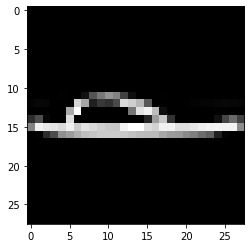

In [626]:
i += 1
print(i)
plt.imshow(new_center[i].reshape(28,28), cmap='gray')
plt.show()

In [244]:
### check if two centroids are the same (data point)
torch.count_nonzero(torch.cdist(dt.centers.data, dt.centers.data) == 0) - 20

tensor(0)

In [ ]:
#######################33

In [697]:
model = nn.Sequential(
                DistanceTransform(784, 785),
#                 nn.LayerNorm(785),
                nn.Linear(785, 200),
                nn.BatchNorm1d(200),
                nn.LeakyReLU(),
                nn.Linear(200, 50),
                nn.BatchNorm1d(50),
                nn.LeakyReLU(),
                nn.Linear(50, 10))
model.to(device)

Sequential(
  (0): DistanceTransform()
  (1): Linear(in_features=785, out_features=200, bias=True)
  (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=200, out_features=50, bias=True)
  (5): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.01)
  (7): Linear(in_features=50, out_features=10, bias=True)
)

In [698]:
# model[0].centers.requires_grad=False
# model[0].set_centroid_to_data_randomly(train_loader) ## this worked best for preserving locality
model[0].set_centroid_to_data_maxdist(train_loader)

100%|██████████| 1200/1200 [01:31<00:00, 13.06it/s]


In [699]:
new_center = model[0].centers.data
dists = torch.cdist(new_center, new_center)+torch.eye(new_center.shape[0])*1e5
dists.min(dim=0)[0]

tensor([ 8.8612,  8.5540,  8.4128,  9.4768,  9.5310,  8.9553,  8.3608,  9.2763,
         8.9870,  8.6764,  8.8316,  8.8937,  8.6198,  8.4706,  9.0861,  8.9229,
         8.4630,  8.4926,  8.9940,  8.7014,  8.4011,  9.8184,  8.5877,  8.6205,
         8.6561,  8.5815,  8.9213,  9.1166,  8.8288,  8.3679,  8.9834,  9.0604,
         8.8601,  9.1250,  8.6364,  9.3513,  9.4518,  9.0821,  9.5021,  9.5351,
         8.8865,  8.5513,  8.4511,  9.8828,  8.9452,  8.4804,  9.0626,  8.4301,
         8.7621,  8.4590,  8.5756, 10.2608,  9.3030,  8.4000,  8.3575,  9.2908,
        10.5155,  8.7909,  9.3329,  8.8889,  8.5403,  8.9416,  8.3568, 10.1273,
         8.5974,  8.5613,  9.5437,  9.0511,  8.4645,  8.4487,  8.5891,  9.3362,
         8.3846,  8.9739,  8.5601,  8.5198,  8.4852,  9.1017,  8.5626,  9.3372,
         8.5448,  9.1214,  8.8195,  8.5430, 10.5689,  8.8341,  9.7418,  9.0179,
         8.3575,  9.4985,  8.3740,  8.6607, 10.6289,  8.5253,  8.4989,  8.4071,
         8.4014,  8.7339,  8.7561,  8.50

In [700]:
optimizer = optim.Adam(list(model.parameters()), 
                            lr=0.0003, weight_decay=1e-15)
criterion = nn.CrossEntropyLoss()

In [701]:
index = 0
train_accs, test_accs = [], []
model.train()
for epoch in tqdm(list(range(40))):
    train_acc = 0
    train_count = 0
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        yout = model(xx)
        loss = criterion(yout, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)

    train_accs.append(float(train_acc)/train_count*100)
    train_acc = 0
    train_count = 0
    
#     if epoch%5 == 0:
#         print(f"Shifting the centroids to the nearest data point")
#         model[0].set_centroid_to_data(train_loader)

    print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
    test_count = 0
    test_acc = 0
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = model(xx)
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        test_acc += correct
        test_count += len(xx)
    test_accs.append(float(test_acc)/test_count*100)
    print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
    print()

### after each class index is finished training
print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:0.4909895062446594


  2%|▎         | 1/40 [00:34<22:14, 34.21s/it]

Train Acc:80.23%, Test Acc:83.53%

Epoch: 1:0,  Loss:0.5007116198539734


  5%|▌         | 2/40 [01:17<25:01, 39.51s/it]

Train Acc:85.27%, Test Acc:84.91%

Epoch: 2:0,  Loss:0.40888503193855286


  8%|▊         | 3/40 [01:53<23:21, 37.87s/it]

Train Acc:86.64%, Test Acc:85.94%

Epoch: 3:0,  Loss:0.31447920203208923


 10%|█         | 4/40 [02:30<22:30, 37.53s/it]

Train Acc:87.82%, Test Acc:86.21%

Epoch: 4:0,  Loss:0.33561772108078003


 12%|█▎        | 5/40 [03:05<21:26, 36.76s/it]

Train Acc:88.54%, Test Acc:86.55%

Epoch: 5:0,  Loss:0.3545219302177429


 15%|█▌        | 6/40 [03:42<20:45, 36.65s/it]

Train Acc:89.05%, Test Acc:87.20%

Epoch: 6:0,  Loss:0.17725025117397308


 18%|█▊        | 7/40 [04:17<19:49, 36.05s/it]

Train Acc:89.74%, Test Acc:87.18%

Epoch: 7:0,  Loss:0.37626099586486816


 20%|██        | 8/40 [05:03<21:04, 39.50s/it]

Train Acc:90.16%, Test Acc:87.29%

Epoch: 8:0,  Loss:0.3917292356491089


 22%|██▎       | 9/40 [05:40<19:52, 38.48s/it]

Train Acc:90.67%, Test Acc:87.48%

Epoch: 9:0,  Loss:0.18258072435855865


 25%|██▌       | 10/40 [06:18<19:16, 38.55s/it]

Train Acc:90.88%, Test Acc:87.60%

Epoch: 10:0,  Loss:0.1379319429397583


 28%|██▊       | 11/40 [07:03<19:29, 40.34s/it]

Train Acc:91.41%, Test Acc:88.06%

Epoch: 11:0,  Loss:0.1728106141090393


 30%|███       | 12/40 [07:40<18:21, 39.35s/it]

Train Acc:91.89%, Test Acc:88.09%

Epoch: 12:0,  Loss:0.1571287214756012


 32%|███▎      | 13/40 [08:23<18:12, 40.47s/it]

Train Acc:92.03%, Test Acc:88.07%

Epoch: 13:0,  Loss:0.2603271007537842


 35%|███▌      | 14/40 [08:58<16:52, 38.94s/it]

Train Acc:92.35%, Test Acc:88.03%

Epoch: 14:0,  Loss:0.0980091392993927


 38%|███▊      | 15/40 [09:34<15:48, 37.95s/it]

Train Acc:92.73%, Test Acc:88.05%

Epoch: 15:0,  Loss:0.22770167887210846


 40%|████      | 16/40 [10:11<15:05, 37.74s/it]

Train Acc:93.06%, Test Acc:88.00%

Epoch: 16:0,  Loss:0.07938431948423386


 42%|████▎     | 17/40 [10:52<14:48, 38.61s/it]

Train Acc:93.38%, Test Acc:88.27%

Epoch: 17:0,  Loss:0.12158767879009247


 45%|████▌     | 18/40 [11:33<14:24, 39.30s/it]

Train Acc:93.67%, Test Acc:88.06%

Epoch: 18:0,  Loss:0.20041412115097046


 48%|████▊     | 19/40 [12:20<14:32, 41.56s/it]

Train Acc:93.85%, Test Acc:87.46%

Epoch: 19:0,  Loss:0.1563386768102646


 50%|█████     | 20/40 [13:05<14:17, 42.86s/it]

Train Acc:94.04%, Test Acc:88.04%

Epoch: 20:0,  Loss:0.3969346284866333


 52%|█████▎    | 21/40 [14:29<17:26, 55.09s/it]

Train Acc:94.42%, Test Acc:87.96%

Epoch: 21:0,  Loss:0.13629059493541718


 55%|█████▌    | 22/40 [15:10<15:17, 50.96s/it]

Train Acc:94.62%, Test Acc:87.78%

Epoch: 22:0,  Loss:0.04736635833978653


 57%|█████▊    | 23/40 [15:46<13:09, 46.43s/it]

Train Acc:94.73%, Test Acc:88.06%

Epoch: 23:0,  Loss:0.04576302692294121


 60%|██████    | 24/40 [16:24<11:38, 43.68s/it]

Train Acc:95.05%, Test Acc:88.02%

Epoch: 24:0,  Loss:0.20399881899356842


 62%|██████▎   | 25/40 [17:14<11:25, 45.70s/it]

Train Acc:95.24%, Test Acc:88.05%

Epoch: 25:0,  Loss:0.16007471084594727


 65%|██████▌   | 26/40 [17:53<10:10, 43.58s/it]

Train Acc:95.47%, Test Acc:88.13%

Epoch: 26:0,  Loss:0.09060615301132202


 68%|██████▊   | 27/40 [18:33<09:14, 42.66s/it]

Train Acc:95.67%, Test Acc:88.10%

Epoch: 27:0,  Loss:0.11192476004362106


 70%|███████   | 28/40 [19:11<08:14, 41.25s/it]

Train Acc:95.91%, Test Acc:87.94%

Epoch: 28:0,  Loss:0.18105722963809967


 72%|███████▎  | 29/40 [20:06<08:17, 45.24s/it]

Train Acc:96.15%, Test Acc:88.12%

Epoch: 29:0,  Loss:0.06307318806648254


 75%|███████▌  | 30/40 [20:52<07:36, 45.64s/it]

Train Acc:96.30%, Test Acc:87.91%

Epoch: 30:0,  Loss:0.08738002181053162


 78%|███████▊  | 31/40 [21:29<06:26, 42.95s/it]

Train Acc:96.50%, Test Acc:88.17%



 78%|███████▊  | 31/40 [21:32<06:15, 41.70s/it]


KeyboardInterrupt: 

In [702]:
# torch.save(model.state_dict(), "./temp_01_2_model_nov26.pth")
torch.save(model.state_dict(), "./temp_01_2_model_nov26_v3.pth")

# model.load_state_dict(torch.load("./temp_01_2_model_nov26.pth", map_location=device))

In [116]:
# -> MAX Train Acc 87.678 ; Test Acc 85.87  ### after distance transformation
# -> MAX Train Acc 98.1367 ; Test Acc 89.22 ### after distance normalization
# -> MAX Train Acc 98.6317 ; Test Acc 89.36 ### after distance normalization and -ve exp
# -> MAX Train Acc 97.255 ; Test Acc 89.01  ### normal nn

In [ ]:
### with 20 input units
-> MAX Train Acc 90.65833333333333 ; Test Acc 87.45 ## 20 centroids
-> MAX Train Acc 92.34166666666667 ; Test Acc 87.54 ## 20 linear transforms

In [914]:
model.eval()
xx = train_dataset[np.random.randint(0, len(train_dataset), 50)][0].to(device)
dists = model[0](xx)
# dists = model[1](dists)
model.train()
dists.shape

torch.Size([50, 785])

In [915]:
dists.mean()

tensor(0.0097, grad_fn=<MeanBackward0>)

In [916]:
dists.std()

tensor(0.0535, grad_fn=<StdBackward0>)

In [917]:
model[0].scaler

Parameter containing:
tensor([2.0417], requires_grad=True)

## UMAP - from library

In [918]:
import umap

In [936]:
embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1)
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [937]:
center_lbl = model(model[0].centers.data)
output_cent = torch.softmax(center_lbl, dim=1).argmax(dim=1).data.cpu().numpy()
# output_cent = center_lbl.data.cpu().numpy()

torch.unique(torch.softmax(center_lbl, dim=1).argmax(dim=1), return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([ 83,  22, 106,  49,  60, 140, 134,  22, 122,  47]))

In [938]:
centers = model[0].centers.data.cpu().numpy()

embedding = embed.fit_transform(centers)
# embedding = embed.fit_transform(centers, output_cent)

In [939]:
i = 0

14/50


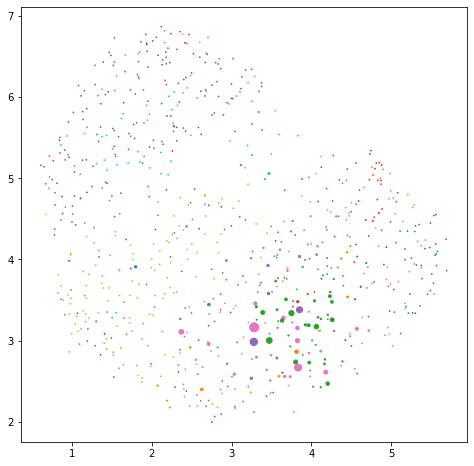

In [957]:
activ = dists.data.cpu().numpy()[i]
# activ = activ - activ.min()
# activ = torch.exp(-activ)
i += 1
print(f"{i}/{len(dists)}")
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*80, 0.5), cmap="tab10")

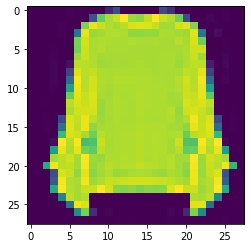

In [958]:
plt.imshow(xx.cpu()[i].reshape(28,28))

## TSNE

In [374]:
from sklearn.manifold import TSNE

In [375]:
tsne = TSNE(n_components=2)
embt = tsne.fit_transform(centers)

In [376]:
embt

array([[  1.4580057,  30.924614 ],
       [-10.764568 , -36.318943 ],
       [-23.901247 ,  16.020674 ],
       ...,
       [ 28.645653 ,  27.828188 ],
       [ -1.4484131,  12.8225   ],
       [  0.8708845,  16.56753  ]], dtype=float32)

In [430]:
i = 0

0/50


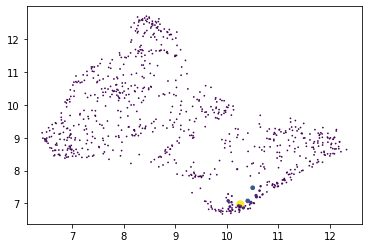

In [431]:
activ = dists.data.cpu()[i]
# activ = activ - activ.min()
# activ = torch.exp(-activ)
print(f"{i}/{len(dists)}")
i += 1
# plt.scatter(embt[:,0], embt[:, 1], c=activ, marker=".")
plt.scatter(embedding[:,0], embedding[:, 1], c=activ, s=np.maximum(activ*50, 0.5))#, cmap="Greys")

### Centroid Visualization